In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
from config import mod7_params, fred_dict, recession_dict

In [3]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels
from gEconpy.plotting import plotting as gp


import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results
from src.process_data import load_data

import numpy as np
import pandas as pd

import os

from config import plt_config
plt.rcParams.update(plt_config)

load model

In [4]:
mod = gEconModel(os.path.join(MODEL_DIR, 'gEconpy_mod7_nk.gcn'), verbose=True)

Model Building Complete.
Found:
	24 equations
	24 variables
	The following "variables" were defined as constants and have been substituted away:
		B_t
	4 stochastic shocks
		 0 / 4 has a defined prior. 
	17 parameters
		 0 / 17 has a defined prior. 
	2 calibrating equations
	2 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [6]:
# assign parameters
mod.free_param_dict.update(mod7_params)

In [7]:
mod.steady_state()
mod.solve_model()
mod.check_bk_condition();

Steady state found! Sum of squared residuals is 1.3485582662688972e-25
Solution found, sum of squared residuals:  2.099219108031363e-28
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 14 eigenvalues greater than one in modulus and 11 forward-looking variables.
Blanchard-Kahn condition is satisfied.


In [8]:
# param prior - beta min = 0, max = 1, beta dist
# gamma for sigmas and alpha

# draw from prior 
# free_param_dict.update_priors

#### drawing from priors

In [9]:
from scipy.stats import gamma, norm, beta
import scipy

In [68]:
beta(1.4, 10).pdf(0.8)

1.3622591269898854e-05

In [69]:
prior_dict = {
    'alpha': beta(1.4, 10),
    # 'beta': beta(.9, 1.5),
    # 'sigma_C': gamma(a=3.9, loc=0, scale=0.757575757575758),
    # 'sigma_L': gamma(a=3.9, loc=0, scale=0.757575757575758)
            }

In [73]:
%%capture
succes = []
sample_dict = {}

for i in range(0, 10):
    
    # reset params
    mod.free_param_dict.update(mod7_params)
    
    # update params
    for key in prior_dict.keys():
        mod.free_param_dict[key] = prior_dict[key].rvs().round(3)
        
    # check for steady state
    mod.steady_state()
    
    # solve model, capture LinAlgEr
    try:
        mod.solve_model()
        is_solved = mod.steady_state_solved
    except Exception as e:
        succes.append(False)
        continue
        
    
    # check blanchard kahn
    is_bk = mod.check_bk_condition(return_value='bool')
    
    if is_bk and is_solved:
        sample_dict[i] = {
            'free_param_dict': mod.free_param_dict,
            'T': mod.T,
            'R': mod.R
        }
        succes.append(True)
    else:
        succes.append(False)

In [74]:
sample_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 7, 8, 9])

In [ ]:
np.mean(succes)

0.9

## Estimation

#### load data

In [120]:
df = load_data('prepro_data.csv', DATA_DIR, fred_dict)
df = df.rename(columns={'pi_s': 'pi_obj'}).drop(['pi_c', 'Ix', 'Zx'], axis=1)
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


In [134]:
from filterpy.kalman import KalmanFilter

In [135]:
sample = sample_dict[1].copy()

In [136]:
observed = ["Y", "pi_obj"]

filter_vars = list(sample['T'].index[len(sample['T']) - (sample['T'] == 0).sum() != 0])

for i in observed:
    assert (i in filter_vars) == True, f"{i} not in filter_vars"
    
xdim = len(filter_vars)
zdim = len(observed)
print(f'xdim: {xdim} \nzdim: {zdim}')

xdim: 9 
zdim: 2


In [137]:
F = sample_dict[1]['T'].loc[filter_vars, filter_vars].values
F.shape

(9, 9)

In [153]:
R = np.eye(zdim) * 0.01
R

array([[0.01, 0.  ],
       [0.  , 0.01]])

In [154]:
filter_vars

['C',
 'I',
 'K',
 'Y',
 'pi_obj',
 'r_G',
 'shock_preference',
 'shock_technology',
 'w']

In [155]:
kfilter = KalmanFilter(dim_x=xdim, dim_z=zdim)
kfilter.F = F
kfilter.R = R
kfilter.H[0, 3] = 1
kfilter.H[1, 4] = 1
kfilter.H

array([[0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [161]:
zs = train[observed].values

In [162]:
# kfilter.predict()
# kfilter.update(zs[0])

In [184]:
mu, cov, _, _ = kfilter.batch_filter(zs)
mu = pd.DataFrame(mu.reshape(-1,9), columns=filter_vars, index=train.index)

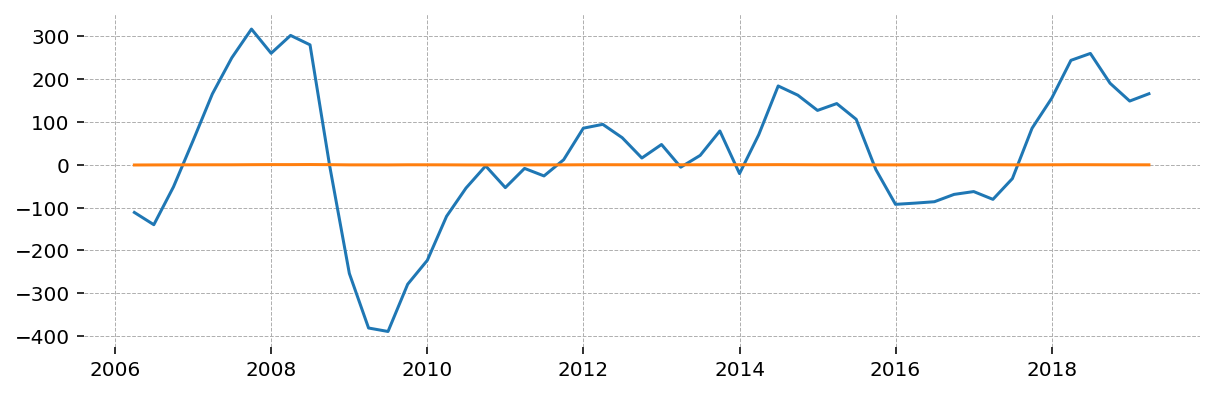

In [187]:
plt.plot(mu.C, label='filter')
plt.plot(train.C, label='data')